# ENV

In [22]:
import pandas as pd

Добавляем Environment для крестиков-ноликов из лекции:

In [1]:
import gym
import numpy as np

import tqdm

N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None

        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]

    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

 # RL and Advanced DL: Домашнее задание 2
## Часть первая: крестики-нолики при помощи Q-обучения
### Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [38]:
class Q_learning:

    def __init__(self,
                 n_rows: int = 3,
                 n_cols: int = 3,
                 n_win: int = 3,
                 lr: float = 0.01,
                 gamma: float = 1.0):
        self.lr = lr
        self.gamma = gamma
        self.env = TicTacToe()

    def get_possible_actions(self) -> list:
        return [self.env.int_from_action(self.env.getEmptySpaces()[i]) for i in range(len(self.env.getEmptySpaces()))]

    def greedy_strategy(self, env: type(TicTacToe), Q: dict, epsilon: float = 0.01):
        possible_actions = self.get_possible_actions()
        if env.getState()[0] not in Q.keys():
            Q[env.getState()[0]] = np.zeros(len(self.get_possible_actions()))

        if np.random.random() > epsilon:
            return np.argmax(Q[env.getState()[0]]), self.get_possible_actions()[np.argmax(Q[env.getState()[0]])]
        else:
            ch = np.random.choice(len(possible_actions))
            return ch, possible_actions[ch]

    def game(self, env: type(TicTacToe), Q: dict, crosses: int = 1):
        env.reset()
        opponent_action = lambda: np.random.choice(self.get_possible_actions())

        if env.curTurn != crosses:
            env.step(env.action_from_int(opponent_action()))

        while True:
            state = env.getState()[0]
            q_action, action = self.greedy_strategy(env, Q)
            _, reward, done, _ = env.step(env.action_from_int(action))
            reward = crosses * reward

            if done:
                Q[state][q_action] += self.lr * (reward  - Q[state][q_action])
                return reward
            else:
                next_state_, reward, done, _ = env.step(env.action_from_int(opponent_action()))
                reward = crosses * reward
                if done:
                    Q[state][q_action] += self.lr * (reward  - Q[state][q_action])
                    return reward
                else:
                    next_state = next_state_[0]
                    if next_state in Q.keys():
                        Q[state][q_action] += self.lr * (reward + self.gamma * np.max(Q[next_state]) - Q[state][q_action])
                    else:
                        Q[next_state] = np.zeros(len(self.get_possible_actions()))
                        Q[state][q_action] += self.lr * (reward + self.gamma * np.max(Q[next_state]) - Q[state][q_action])


    def games(self, n_games=100000, crosses=1):
        Q = {}
        rewards = [self.game(self.env, Q, crosses=crosses) for _ in tqdm.tqdm(range(n_games))]
        return Q, rewards

#### 3 x 3 x 3

In [39]:
games = Q_learning(n_rows=3, n_cols=3, n_win=3)
Q_crosses, rewards_crosses  = games.games()

100%|██████████| 100000/100000 [00:25<00:00, 3917.45it/s]


<AxesSubplot: >

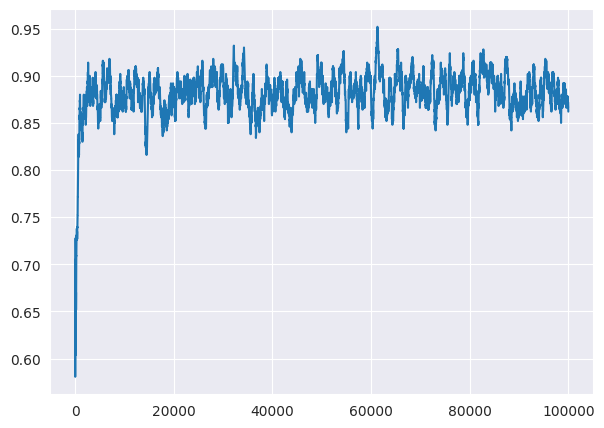

In [40]:
pd.Series(rewards_crosses).rolling(500, step=10, min_periods=10).mean().plot(figsize=(7, 5), grid=True)

### Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

#### 4 x 4 x 4

In [41]:
games = Q_learning(n_rows=4, n_cols=4, n_win=4)
Q_crosses, rewards_crosses  = games.games()

100%|██████████| 100000/100000 [00:25<00:00, 3986.78it/s]


<AxesSubplot: >

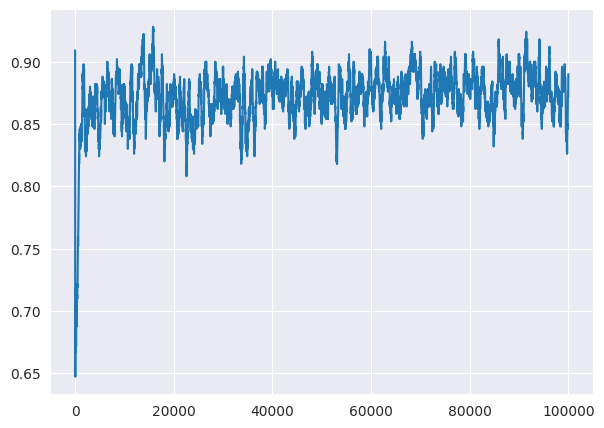

In [42]:
pd.Series(rewards_crosses).rolling(500, step=10, min_periods=10).mean().plot(figsize=(7, 5), grid=True)

#### 5 x 5 x 5

In [34]:
games = Q_learning(n_rows=5, n_cols=5, n_win=5)
Q_crosses, rewards_crosses  = games.games()

100%|██████████| 100000/100000 [00:25<00:00, 3946.88it/s]


<AxesSubplot: >

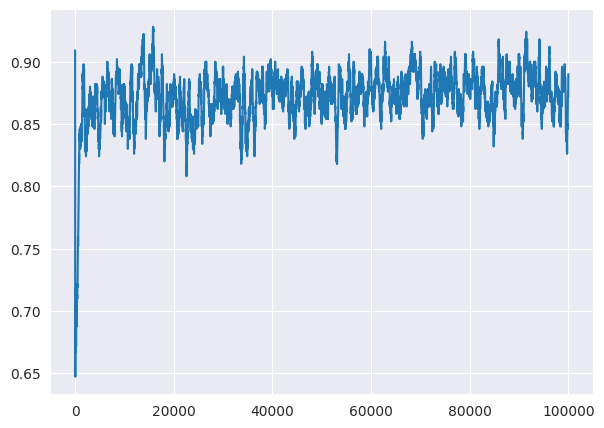

In [43]:
pd.Series(rewards_crosses).rolling(500, step=10, min_periods=10).mean().plot(figsize=(7, 5), grid=True)

## Часть вторая: добавим нейронных сетей

### Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов

### Реализуйте Double DQN и/или Dueling DQN

## Часть третья: расширим и углубим поиск

## Часть четвёртая, опциональная: AlphaZero